# Evaluate model performance at the aggregate level

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from scipy.stats import binom
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

## Load test data with predictions

## Overall accuracy

In [2]:
df_test = pd.read_pickle('customer_value.pkl')
df_test.head(10)

,is_converted,revenue,shop,landing_product_type,medium,keyword,predicted_conversion,predicted_value
1,True,21.0,gb,(homepage),cpc,made,0.248844,39.048443
2,False,0.0,gb,Upholstery,cpc,product_type_l1==sofas&+product_type_l2==sofa ...,0.003297,0.764168
3,False,0.0,fr,Lighting,cpc,Dynamic Search Ads,0.001134,0.077723
4,False,0.0,gb,(homepage),(none),(not set),0.018975,8.278039
5,False,0.0,es,Downstairs Furniture,social_paid,(not set),0.000263,0.045342
6,False,0.0,fr,Downstairs Furniture,social_paid,(not set),0.000104,0.012734
8,False,0.0,gb,Upholstery,cpc,product_type_l1==sofas&+product_type_l2==loves...,0.006745,1.996706
11,False,0.0,de,Lifestyle,cpc,product_type_l1==*,0.002772,0.127577
12,False,0.0,fr,Upholstery,email,(not set),0.001458,0.344060
14,False,0.0,gb,Upholstery,cpc,+made +sofas,0.003381,0.793502


## Overall accuracy

In [3]:
conv_rate_true = df_test['is_converted'].mean()
conv_rate_pred = df_test['predicted_conversion'].mean()
value_true = df_test['revenue'].mean()
value_pred = df_test['predicted_value'].mean()


conv_accuracy_err = (conv_rate_pred / conv_rate_true - 1.) * 100.
value_accuracy_err = (value_pred / value_true - 1.) * 100.
print("Accuracy error in conversion rate: {:.2f}%".format(conv_accuracy_err))
print("Accuracy error in customer value: {:.2f}%".format(value_accuracy_err))

Accuracy error in conversion rate: -8.06%
Accuracy error in customer value: -3.46%


The model sligtly underpredicts the conversion rate and customer value, but accurate to within 5%.

This is partly due to seasonality variations in the conversion rate, since the period used for the beta calibration had a sligthly lower conversion rate, than that of the test period.

## Aggregate results

In [4]:
def aggregate_stats(df, on):
    #observed
    agg = {'is_converted': [
                ('n_visitors', 'count'),
                ('conversion_rate_true', lambda x: np.mean(x) * 100.),
                ],
           'revenue': [
                ('revenue_per_visitor_true', 'mean'),
                ],
           'predicted_conversion': [
                ('conversion_rate_pred', lambda x: np.mean(x) * 100.),
                ],
           'predicted_value': [
                ('revenue_per_visitor_pred', 'mean'),
                ],
          }
    df = df_test.groupby(on).agg(agg)
    df = df.droplevel(level=0, axis=1)
    
    df.insert(1, 'percentage_of_traffic', 100 * df['n_visitors'] / float(df['n_visitors'].sum()))
    
    return df

### per shop

In [5]:
df_shop = aggregate_stats(df_test, 'shop')
df_shop = df_shop.sort_values('n_visitors', ascending=False).reset_index()
df_shop

,shop,n_visitors,percentage_of_traffic,conversion_rate_true,revenue_per_visitor_true,conversion_rate_pred,revenue_per_visitor_pred
0,gb,359723,42.987673,1.429989,4.733778,1.310148,4.504212
1,fr,179982,21.508237,0.979542,1.686094,0.910051,1.629935
2,de,141992,16.968350,1.243732,1.734761,1.104754,1.704046
3,nl,93198,11.137362,1.166334,1.487793,1.117050,1.589646
4,es,49677,5.936509,0.432796,0.532380,0.414746,0.570201
5,ch,10379,1.240313,0.606995,2.224906,0.531303,2.188051
6,dk,1122,0.134081,0.000000,0.000000,0.447676,1.124854
7,se,732,0.087476,0.273224,1.782599,0.536789,2.187029


### per landing product

In [6]:
df_product = aggregate_stats(df_test, 'landing_product_type')
df_product = df_product.sort_values('n_visitors', ascending=False).reset_index()
df_product

,landing_product_type,n_visitors,percentage_of_traffic,conversion_rate_true,revenue_per_visitor_true,conversion_rate_pred,revenue_per_visitor_pred
0,(homepage),195982,23.420271,2.130808,6.123767,1.970213,5.948146
1,Upholstery,150323,17.963922,0.675878,2.171332,0.621717,2.172242
2,Downstairs Furniture,128968,15.411954,0.749023,2.052359,0.670570,1.763534
3,(multiple),80195,9.583475,1.034977,2.513295,1.022284,2.599279
4,Upstairs Furniture,70408,8.413908,0.701625,2.408970,0.649917,2.215787
5,Lighting,55653,6.650653,1.505759,1.663462,1.420191,1.593916
6,Lifestyle,41610,4.972485,0.910839,0.651057,0.841174,0.883806
7,Home Accessories,31061,3.711856,1.187985,1.095077,0.931518,1.032423
8,Outdoor & Leisure,27478,3.283680,0.531334,1.775122,0.515807,1.461728
9,Kitchen & Dining Accs,22408,2.677804,1.606569,0.940638,1.395701,1.029246


### per keyword 

In [7]:
df_keyword = df_test[df_test['medium'].str.contains('cpc')]
df_keyword = aggregate_stats(df_keyword, 'keyword')
df_keyword = df_keyword.sort_values('n_visitors', ascending=False).reset_index()

# only keep fequently used
df_keyword = df_keyword[(df_keyword['n_visitors'] > 2000) & ~df_keyword['keyword'].isin(['(not set)', '(not provided)'])] 
df_keyword

,keyword,n_visitors,percentage_of_traffic,conversion_rate_true,revenue_per_visitor_true,conversion_rate_pred,revenue_per_visitor_pred
2,Dynamic Search Ads,28627,3.421074,0.551927,1.358949,0.413305,1.021240
3,made,17804,2.127670,3.173444,8.169260,2.843108,7.923457
4,*,13007,1.554404,0.891827,1.250275,0.761158,1.221936
5,made com,5496,0.656800,2.983988,8.885297,2.859980,7.484751
6,product_type_l1==*,4570,0.546139,1.203501,0.815071,1.317629,1.069992
7,made.com,3831,0.457824,3.315061,7.259312,2.720526,6.743007
8,(automatic matching),3756,0.448861,0.079872,0.056707,0.486541,0.598081
9,stacarima00scat-armcugc-content,3177,0.379668,0.062952,0.022691,0.040144,0.069298
10,profile link,3139,0.375127,0.063715,0.090475,0.114262,0.310794
11,product_type_l1==sofas&+product_type_l2==sofas...,3023,0.361264,0.363877,0.503633,0.298387,0.453673


## Is the model accurate when divided into subcategories?

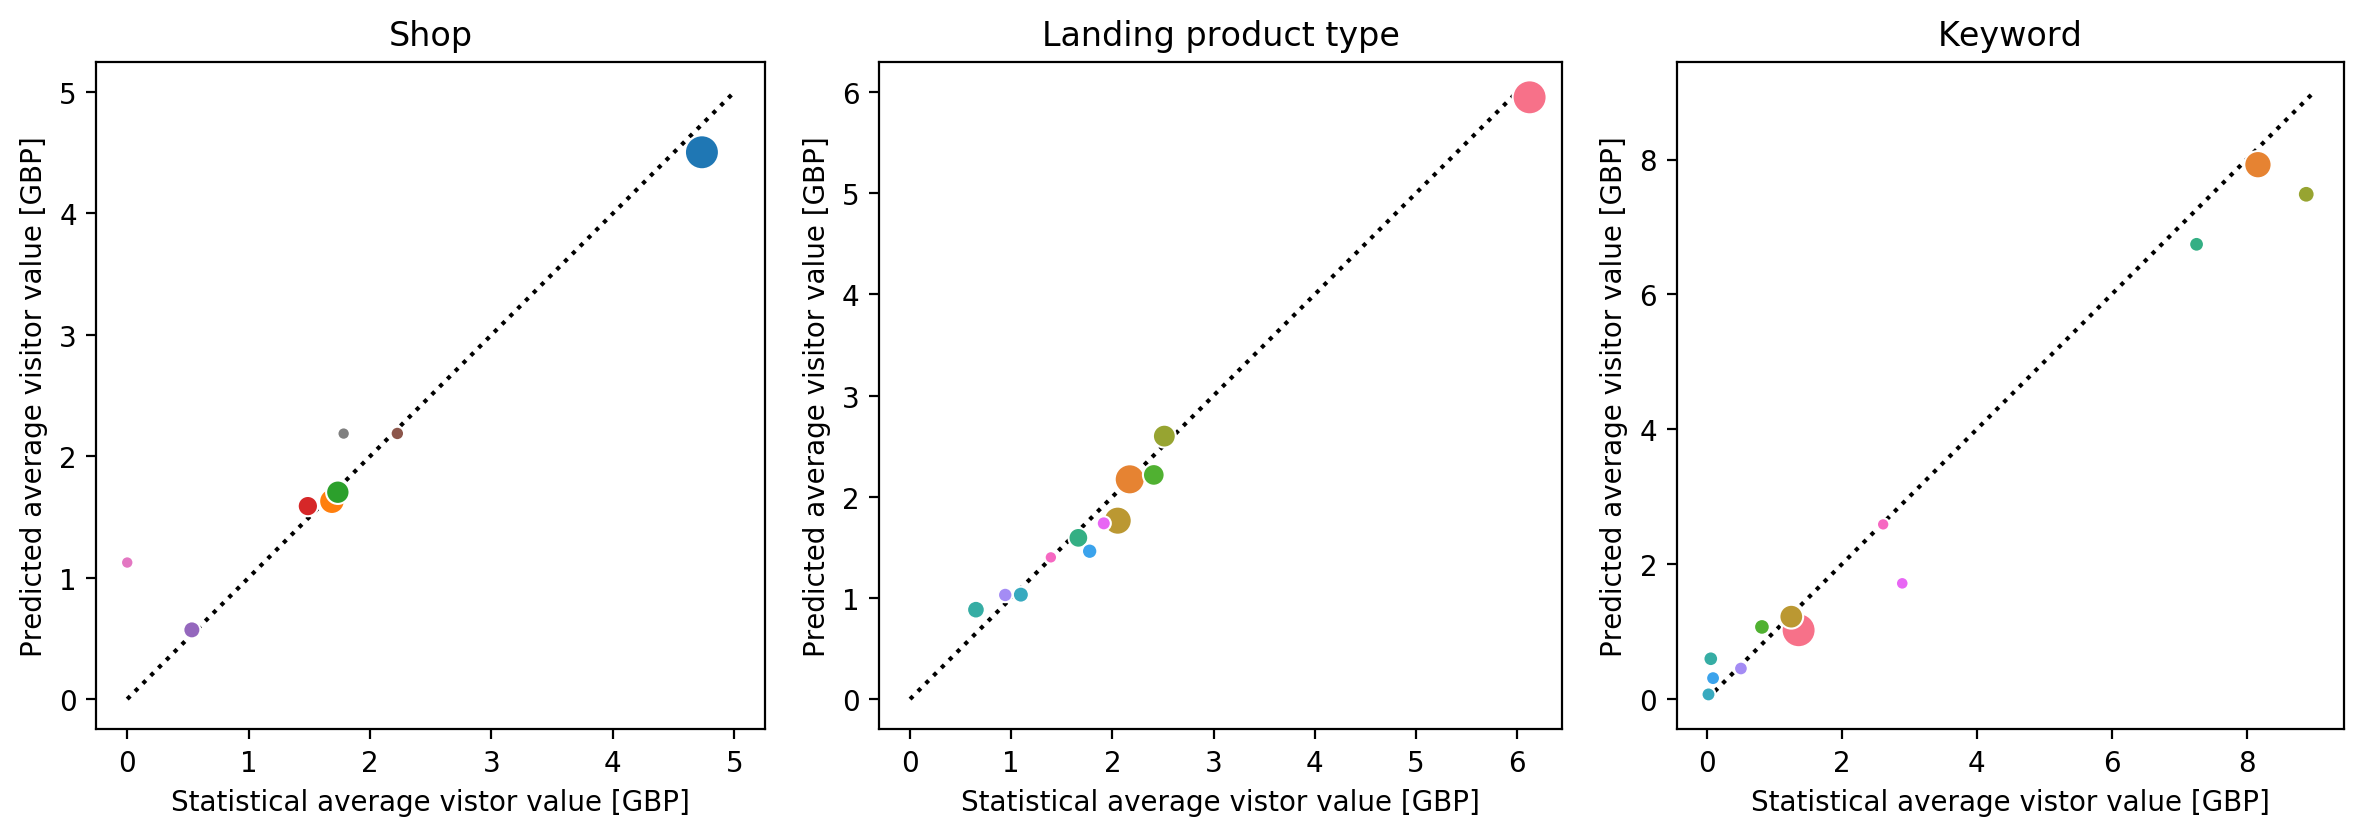

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), dpi=200,
                                   tight_layout=True)

sizes = (20, 150)

s = sns.scatterplot(x='revenue_per_visitor_true', y='revenue_per_visitor_pred', 
                    size='n_visitors', hue='shop', data=df_shop,
                    ax=ax1, legend=False, sizes=sizes)

s = sns.scatterplot(x='revenue_per_visitor_true', y='revenue_per_visitor_pred',
                    size='n_visitors', hue='landing_product_type', data=df_product,
                    ax=ax2, legend=False, sizes=sizes)

s = sns.scatterplot(x='revenue_per_visitor_true', y='revenue_per_visitor_pred',
                    size='n_visitors', hue='keyword', data=df_keyword,
                    ax=ax3, legend=False, sizes=sizes)

for ax in [ax1, ax2, ax3]:
    ax.set_aspect(1)
    ax.set_xlabel("Statistical average vistor value [GBP]")
    ax.set_ylabel("Predicted average visitor value [GBP]")
    
ax1.plot([0, 5], [0, 5], ':', c='k', zorder=-1)
ax2.plot([0, 6], [0, 6], ':', c='k', zorder=-1)
ax3.plot([0, 9], [0, 9], ':', c='k', zorder=-1)

ax1.set_title('Shop')
ax2.set_title('Landing product type')
ax3.set_title('Keyword')

plt.show()

Accuracy of the model is still retained when divided by shop, product type and keyword.

N.B. for a small number of visitors, there is considerable uncertaintly in both axes

## How precise is the two-step model vs the statistical method?

Considering only the UK shop (with 360000 visitors), we can get a very good estimate "ground truth"

In [9]:
df_test_gb = df_test[df_test['shop'] == 'gb']

conversion_rate_true = df_test_gb.is_converted.mean()
value_true = df_test_gb.revenue.mean()

print("Ground truth conversion rate: {:.2f}%".format(conversion_rate_true * 100.))
print("Ground truth visitor value: {:.2f} GBP".format(value_true))

Ground truth conversion rate: 1.43%
Ground truth visitor value: 4.73 GBP


Statistically the we expect the number of observed conversions to follow a binomial distribution.

So the standard deviation in the number of observed converions is $\sqrt{N p (1-p)}$, where $p$ is the true conversion probability, and $N$ is the total number of visitors.

Therefore the error in the estimated probability is $\displaystyle \sqrt{\frac{p (1-p)}{N}}$.

I.e. error in the probability scales proportionally with $\displaystyle \propto \frac{1}{\sqrt{N}}$.

Calculately the error in the two-step model cannot be done analytically.
However, if we take a random sub-sample (for example of only 1000 visitor) we can derive a predicted conversion rate from the model.

Repeating this a large number times for different sub-samples we can can measure the scatter in the model prediciton. This should represent the upper-bounds on the model error.

We can also calculate the error on the visitor value the same way (for both the statistical and two-step model methods).

In [10]:
#for sample sizes ranging between 1 and 100000
n_sample = np.logspace(0,5,11).astype(int)

#theoretical error from binomial distribution
conv_samp_err_theo = binom.std(n_sample, conversion_rate_true) / n_sample.astype(float)

#empty arrays for storing results
conv_samp_err = []
conv_pred_err = []
value_samp_err = [] 
value_pred_err = []

random_state = np.random.RandomState(0)
for n in n_sample:
    #for smaller sample sizes perform more Monte Carlo iterations
    n_mc = int(np.clip(1e5 / n, 100, 10000))
    
    conv_samp_mc = []
    conv_pred_mc = []
    value_samp_mc = []
    value_pred_mc = []
    for _ in range(n_mc):
        #compute sub-sample estimates
        df = df_test_gb.sample(n, replace=True, random_state=random_state)
        conv_samp_mc.append(df['is_converted'].mean())
        conv_pred_mc.append(df['predicted_conversion'].mean())
        value_samp_mc.append(df['revenue'].mean())
        value_pred_mc.append(df['predicted_value'].mean())
        
    #compute scatter in estimates
    conv_samp_err.append(np.std(conv_samp_mc, ddof=1))
    conv_pred_err.append(np.std(conv_pred_mc, ddof=1))
    value_samp_err.append(np.std(value_samp_mc, ddof=1))
    value_pred_err.append(np.std(value_pred_mc, ddof=1))
    
#convert to numpy arrays
conv_samp_err = np.array(conv_samp_err)
conv_pred_err = np.array(conv_pred_err)
value_samp_err = np.array(value_samp_err)
value_pred_err = np.array(value_pred_err)

Compare sampling matches theoretical expectation, not guarenteed if there is not a good single "ground-truth"

In [11]:
print(conv_samp_err / conv_samp_err_theo)

[0.99660145 0.96604971 1.00890612 1.00657913 0.98322196 1.04507054
 0.92916725 0.96603577 1.01669079 0.92508607 0.985528  ]


Good enough

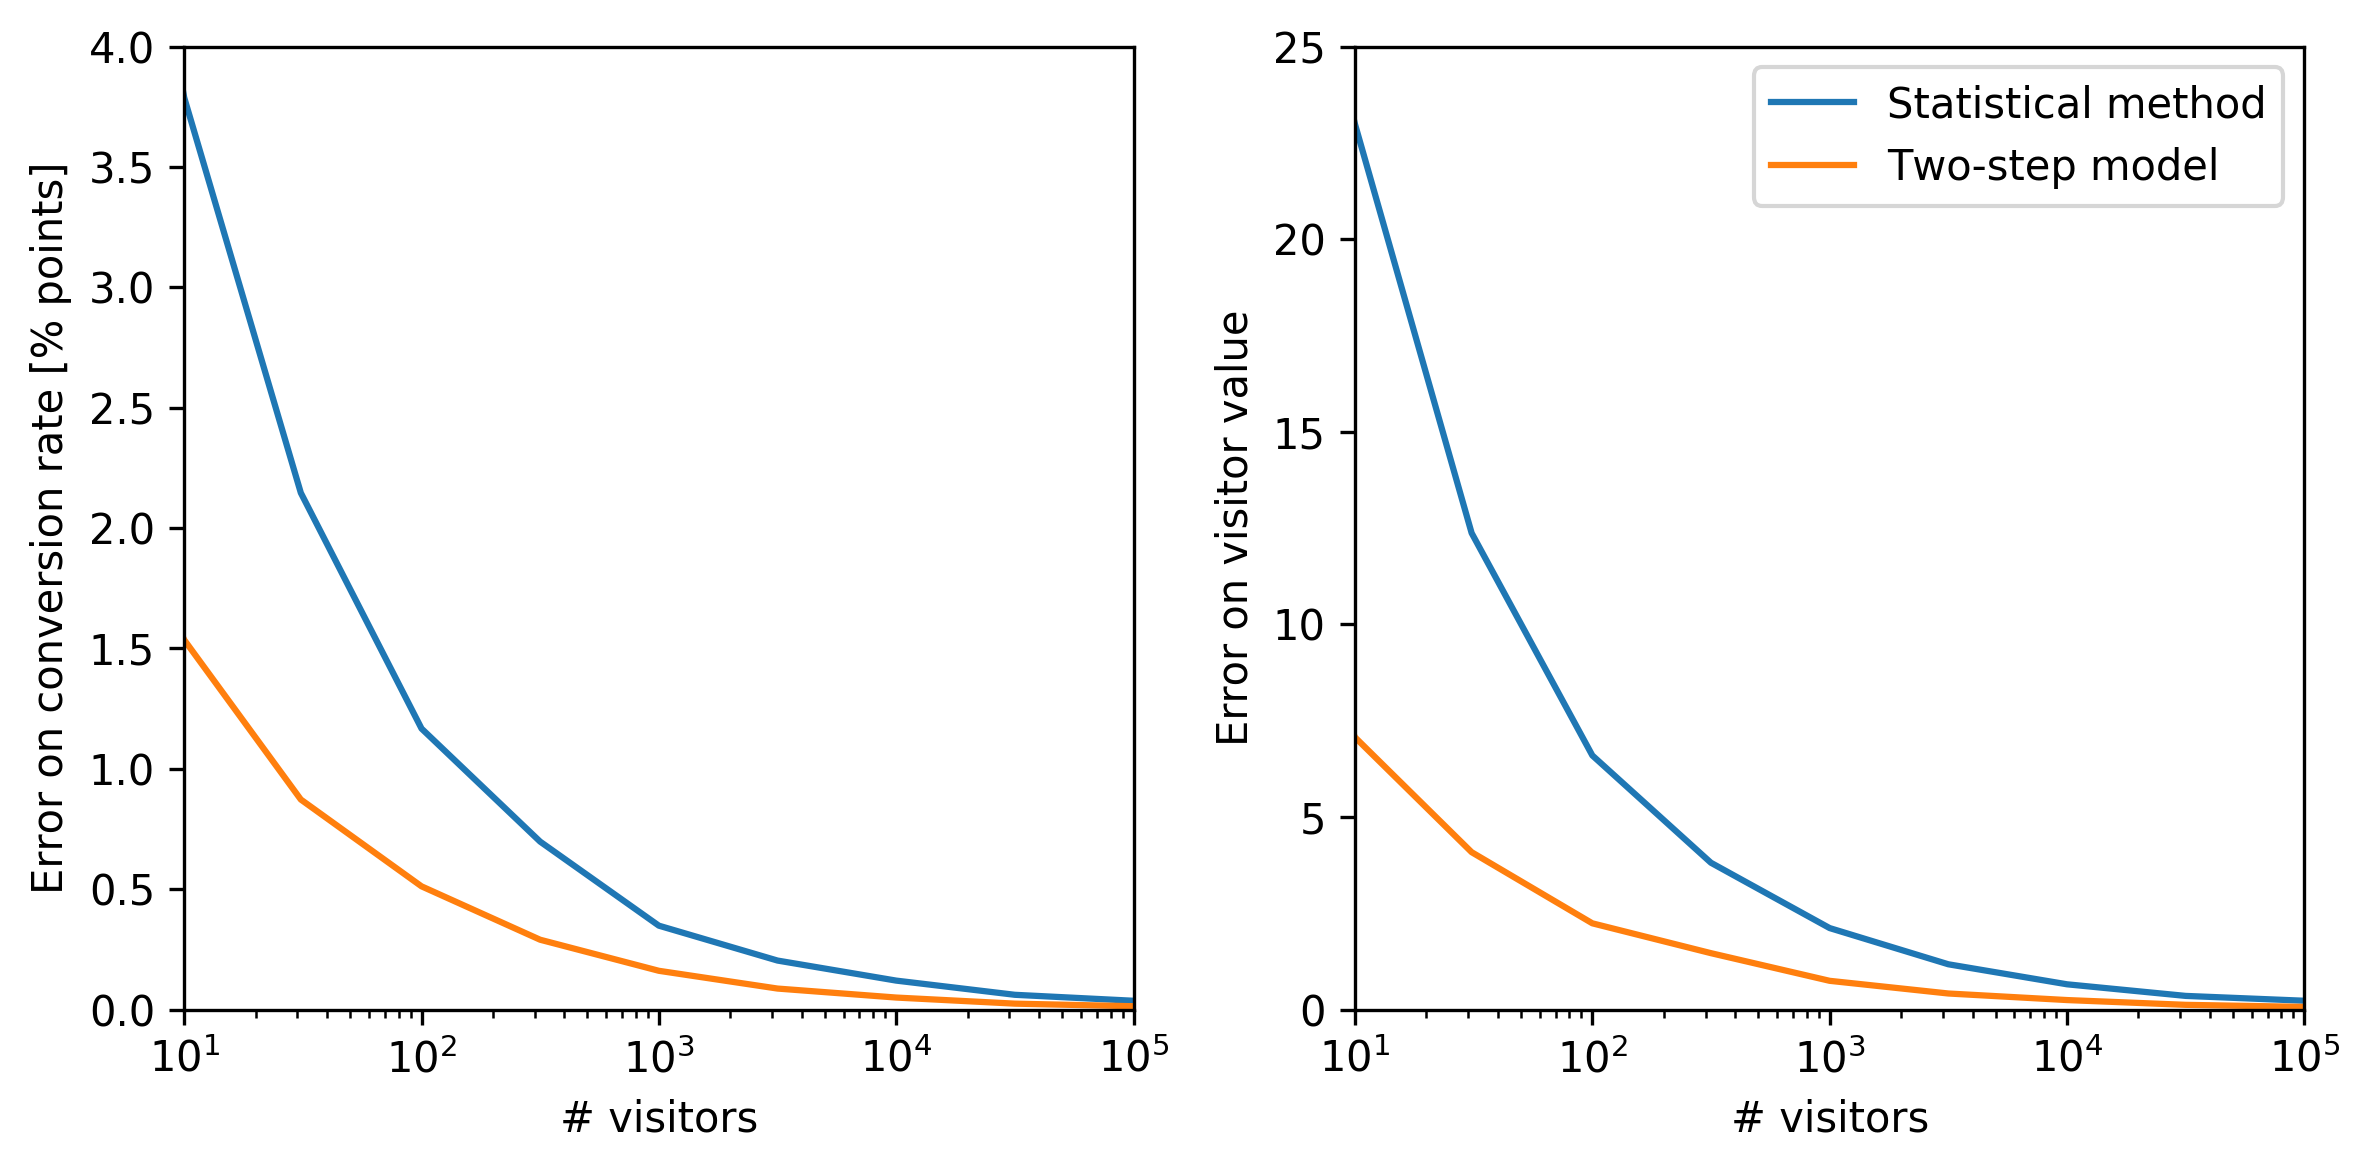

In [12]:
fig, (ax1, ax2),  = plt.subplots(1, 2, figsize=(8,4), dpi=300, tight_layout=True)

ax1.plot(n_sample, conv_samp_err * 100, label='Statistical method')
ax1.plot(n_sample, conv_pred_err * 100, label='Two-step model')

ax2.plot(n_sample, value_samp_err, label='Statistical method')
ax2.plot(n_sample, value_pred_err, label='Two-step model')

ax2.legend()

ax1.set_xscale('log')
ax1.set_xlabel("# visitors")
ax1.set_ylabel("Error on conversion rate [% points]")

ax1.set_xlim([10,100000])
ax1.set_ylim([0,4])

ax2.set_xscale('log')
ax2.set_xlabel("# visitors")
ax2.set_ylabel("Error on visitor value")

ax2.set_xlim([10,100000])
ax2.set_ylim([0, 25])

plt.show()

Both methods have the same $\frac{1}{\sqrt{n}}$ scaling in precision. But for a fixed number of visitors the model out-performs the statistical method.

In [13]:
conv_rate_improvement = np.mean((1 - (conv_pred_err / conv_samp_err)) * 100)
value_improvement = np.mean((1 - (value_pred_err / value_samp_err)) * 100)

print("Model reduces error on conversion rate by ~{:.0f}%".format(conv_rate_improvement))
print("Model reduces error on visitor value by ~{:.0f}%".format(value_improvement))

Model reduces error on conversion rate by ~59%
Model reduces error on visitor value by ~65%


Given the $\frac{1}{\sqrt{n}}$ scaling, to reduce the error in the statistical method by $X\%$, one would need to increase the $n$ by a factor

$\displaystyle \frac{n_{\rm new}}{n} \approx \left(1 - \frac{X}{100}\right)^{-2}$

if the error in the visitor value scales similarly, a 65% improvement in error equates to needing 8x or 9x less data

However the improvement in data volumn can be obtained by iterpolating between the two curves

In [14]:
print(n_sample)
print(np.interp(value_pred_err, value_samp_err[::-1], n_sample[::-1])  / n_sample)

[     1      3     10     31    100    316   1000   3162  10000  31622
 100000]
[13.21407621  8.98614768  9.43701975  9.50749169  9.50143713  7.90486868
  8.8121255   8.58584618  9.04193663  3.16235532  1.        ]


Ignoring the last few (where the interpolation fails), we can see that indeed there is roughly a 9x improvement